## Анализ скачаных твиттов на обученой модели Логистической регрессии

Загрузка сохраненных твиттов

In [1]:
import numpy as np
import pickle
import re

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
all_tweets = pickle.load(open('all_tweets.pkl', 'rb'))
print 'Total tweets:', len(all_tweets)

Total tweets: 10013


Загрузка обученной модели Логистической регрессии (Logistic Regression model)

In [3]:
modelLR = pickle.load(open('TweetLogisticRegression.pkl', 'rb'))
tfidf_vectorizer = pickle.load(open('TweetTfidfVectorizer.pkl', 'rb'))

Удаляем из твиттов все ссылки, цифры, хэштеги, username и прочий мусор, который не нужен для анализа эмоциональной окраски

In [4]:
tweets_clean = []
for s in all_tweets:
    t = ""
    t = re.sub('(http\S+)', "", s)
    t = re.sub('[^a-zA-z]', " ", t)
    t = re.sub('(#\w+)|(@\w+)|(\d+)|(&gt;)|(&lt;)', "", t)
    t = re.sub('^\s+', "", t)
    t = re.sub('\\n', " ", t)
    if t!='':
        tweets_clean.append(t)

После обработки осталовь всего твиттов:

In [5]:
len(tweets_clean)

9464

## Анализ на "позитивные" и "негативные"

Преобразуем очищенные твитты в числовые векторы

In [6]:
tfidf = tfidf_vectorizer.transform(tweets_clean)
tfidf

<9464x500000 sparse matrix of type '<type 'numpy.float64'>'
	with 161960 stored elements in Compressed Sparse Row format>

In [7]:
predicted = modelLR.predict(tfidf)

In [8]:
pos = predicted.sum()
neg = len(tweets_clean)-pos

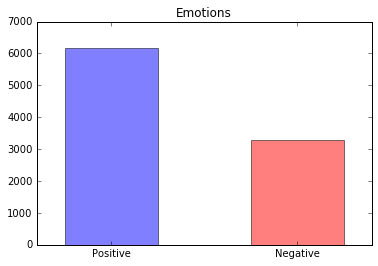

In [9]:
plt.bar([1], [pos], align='center', width=0.5, color='b', alpha=0.5)
plt.bar([2], [neg], align='center', width=0.5, color='r', alpha=0.5)
plt.title('Emotions')
#plt.grid()
plt.xticks([1, 2], ['Positive', 'Negative']);

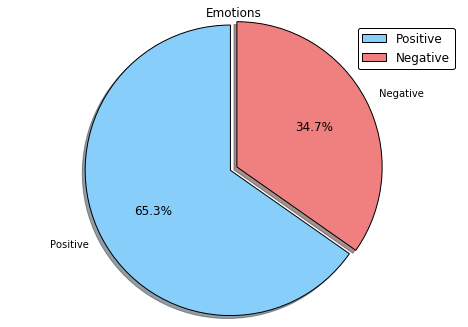

In [137]:
labels = 'Positive','Negative'
sizes = pos, neg
colors = ['lightskyblue', 'lightcoral']
explode = (0, 0.05)

#plt.figure(figsize=(4,4))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90, textprops = {'fontsize' : 12})

plt.axis('equal')
plt.legend(fancybox=True)
plt.tight_layout(rect=(0, 0, 1.1, 1.1))
plt.title('Emotions');

## Классификация на "нейтральные", "позитивные" и "негативные"


### Иерархическая классификация

Сначала выделим нейтральные твитты

In [138]:
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank

In [139]:
PosNeg = []
Neutral = 0
Pos_or_Neg = 0

In [140]:
p = list(opinion_lexicon.positive())
n = list(opinion_lexicon.negative())
tokenizer = treebank.TreebankWordTokenizer()

In [141]:
for i in xrange(len(all_tweets)):
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(all_tweets[i])]
    
    for word in tokenized_sent:
        if word in p:
            Pos_or_Neg += 1 # positive
            PosNeg.append(all_tweets[i])
            break
        elif word in n:
            Pos_or_Neg += 1 # negative
            PosNeg.append(all_tweets[i])
            break

Получили нейтральных твиттов:

In [142]:
Neutral = len(all_tweets) - Pos_or_Neg
Neutral

3778

Удаляем из твиттов все ссылки, цифры, хэштеги, username и прочий мусор, который не нужен для анализа эмоциональной окраски

In [143]:
tweets_clean = []
for s in PosNeg:
    t = ""
    t = re.sub('(http\S+)', "", s)
    t = re.sub('[^a-zA-z]', " ", t)
    t = re.sub('(#\w+)|(@\w+)|(\d+)|(&gt;)|(&lt;)', "", t)
    t = re.sub('^\s+', "", t)
    t = re.sub('\\n', " ", t)
    if t!='':
        tweets_clean.append(t)

Теперь классифицируем твитты на позитивные и негативные.

Преобразуем очищенные твитты в числовые векторы:

In [144]:
tfidf = tfidf_vectorizer.transform(tweets_clean)
tfidf

<6235x500000 sparse matrix of type '<type 'numpy.float64'>'
	with 123731 stored elements in Compressed Sparse Row format>

Классифицируем твитты на на позитивные и негативные. Положительным и отрицательным твиттом будем сичтать с вероятностью от 0.65 и выше, а все, что меньше — нейтральным.

In [148]:
predicted = modelLR.predict_proba(tfidf)

In [352]:
Pos_tweets = []
Neg_tweets = []
Neu_tweets = []

v = 0.55

for i in range(len(predicted)):
    if predicted[i,1]>=v:
        Pos_tweets.append(PosNeg[i])
    elif predicted[i,0]>=v:
        Neg_tweets.append(PosNeg[i])
    else:
        Neu_tweets.append(PosNeg[i])

In [353]:
pos = len(Pos_tweets)
neg = len(Neg_tweets)
neu = len(Neu_tweets)

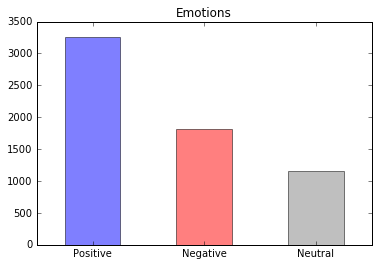

In [354]:
plt.bar([1], [pos], align='center', width=0.5, color='blue', alpha=0.5)
plt.bar([2], [neg], align='center', width=0.5, color='red', alpha=0.5)
plt.bar([3], [neu], align='center', width=0.5, color='gray', alpha=0.5)
plt.title('Emotions')
#plt.grid()
plt.xticks([1, 2, 3], ['Positive', 'Negative', 'Neutral']);

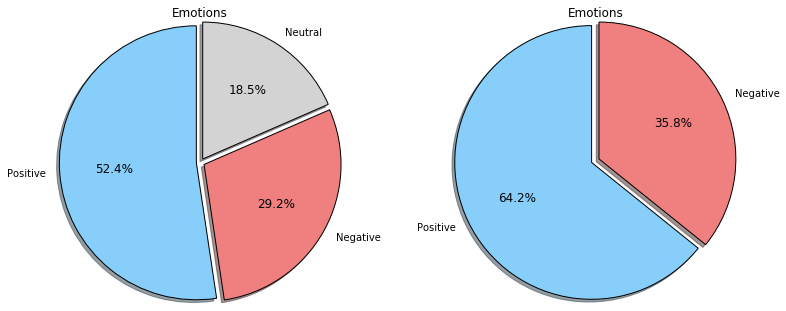

In [355]:
plt.figure(figsize=(13,5))

labels = 'Positive','Negative', 'Neutral'
sizes = pos, neg, neu
colors = ['lightskyblue', 'lightcoral', 'lightgray']
explode = (0.03, 0.03, 0.03)
plt.subplot(121)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90, textprops = {'fontsize' : 12})
plt.axis('equal')
plt.title('Emotions');

labels = 'Positive','Negative'
sizes = pos, neg
colors = ['lightskyblue', 'lightcoral']
explode = (0.03, 0.03)
plt.subplot(122)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90, textprops = {'fontsize' : 12})
plt.axis('equal')
plt.title('Emotions');

### Посмотрим, как классифицировались твитты:

**Позитивные**

In [349]:
for i in range(3):
    print Pos_tweets[i], '\n'

RT @caro: Russia, if you're listening, can you get that Wu-Tang Clan album from that weird hedge fund guy? Thanks 

Scroll down my tweets:  China, Russia, &amp; Netherlands are reading the following articles on my blog.  Thank you. Sincerely, Slim 

of Russian History at Princeton &amp; NYU, one of the few Russia experts in the USA to speak out about the risk of war. https://t.co/rKUST98q5k 



**Негативные**

In [350]:
for i in range(3):
    print Neg_tweets[i], '\n'

Trump asks Russia to send emails,that's a national security risk? 

But,Hillary 33 000 emails? 😫

DNC don't like competition #EmailGate 

RT @imfabulous13: Putin wants to break up NATO. 
Trump wants to break up NATO.
Russia hacks DNC.
Trump softens GOP stance on Ukraine. https… 

@morningmika @Morning_Joe and no mention of Uraniumone and the 20% reserve Russia got through Hillary's help? Fake patriotism #TrumpPence16 



**Нейтральные**

In [351]:
for i in range(3):
    print Neu_tweets[i], '\n'

Krauthammer: Clinton Reaction To Trump's Russia Statement Admitted She Deleted Work-Related Emails - Breitbart https://t.co/v5lnvhFLsw 

RT @Kasparov63: Instead of owing Mitt Romney an apology for his being right on Russia in 2012, what about owing him a candidacy? 

Love this writeup. Wish i did the moscow river and botanical garden tours.

A $1,000 Day in Moscow for $100 https://t.co/iIm4VEfBKX 

